# Would you survive the Titanic using Python

The project is in two parts. First is the analysis of the data. Who did actually survive from the Titatnic? Were their a pattern? Which leads to the second part, Can we predict whether a given passenger would have survived this disaster? The given passenger has the main following criteria : class, sex, and age, and etc.

The project is almost a recapture of the data project done at SocialCops. The project therefore is for a learning purpose. It aims to give one an accessible introduction on how to use machine learning techniques for his projects and data sets; from decision trees to deep neural networks — to a sample data set. 
This is a practical, not a conceptual, introduction; to fully understand the capabilities of machine learning, I highly recommend that you seek out resources that explain the low-level implementations of these techniques.

The libraries required are : 

Python (version 3.5 was used for this tutorial): https://www.python.org
SciPy Ecosystem (NumPy, SciPy, Pandas, IPython, matplotlib): https://www.scipy.org
SciKit-Learn: http://scikit-learn.org/stable/
TensorFlow: https://www.tensorflow.org

From the original work, which the version of Python was 3.4, Tensorflow package has changed a little, and therefore needed a revision in code lines; 1) cross_validation -> model_selection, and 2) the use of DNN estimator.

## The Data at First Glance: Who Survived the Titanic and Why?

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics, ensemble
import tensorflow as tf
import skflow
import xlrd

In [62]:
titanic_df = pd.read_excel('titanic3.xls', 'titanic3', index_col=None, na_values=['NA'])

In [63]:
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


The column heading variables have the following meanings:

survival: Survival (0 = no; 1 = yes)
class: Passenger class (1 = first; 2 = second; 3 = third)
name: Name
sex: Sex
age: Age
sibsp: Number of siblings/spouses aboard
parch: Number of parents/children aboard
ticket: Ticket number
fare: Passenger fare
cabin: Cabin
embarked: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat: Lifeboat (if survived)
body: Body number (if did not survive and body was recovered)

In [64]:
titanic_df['survived'].mean()

0.3819709702062643

In [65]:
titanic_df.groupby('pclass').mean()

,survived,age,sibsp,parch,fare,body
pclass,,,,,,
1,0.619195,39.159918,0.436533,0.365325,87.508992,162.828571
2,0.429603,29.506705,0.393502,0.368231,21.179196,167.387097
3,0.255289,24.816367,0.568406,0.400564,13.302889,155.818182


The calculation shows that only 38% of the passengers survived. Not the best odds. The reason for this massive loss of life is that the Titanic was only carrying 20 lifeboats, which was not nearly enough for the 1,317 passengers and 885 crew members aboard. It seems unlikely that all of the passengers would have had equal chances at survival, so we will continue breaking down the data to examine the social dynamics that determined who got a place on a lifeboat and who did not.

Social classes were heavily stratified in the early twentieth century. This was especially true on the Titanic, where the luxurious first-class areas were completely off limits to the middle-class passengers in second class, and especially to those who carried a third class “economy price” ticket. To get a view into the composition of each class, we can group data by class, and view the averages for each column:

In [66]:
class_sex_grouping = titanic_df.groupby(['pclass','sex']).mean()
class_sex_grouping

survived        age     sibsp     parch        fare        body
pclass sex                                                                    
1      female  0.965278  37.037594  0.555556  0.472222  109.412385         NaN
       male    0.340782  41.029250  0.340782  0.279330   69.888385  162.828571
2      female  0.886792  27.499191  0.500000  0.650943   23.234827   52.000000
       male    0.146199  30.815401  0.327485  0.192982   19.904946  171.233333
3      female  0.490741  22.185307  0.791667  0.731481   15.324250  183.000000
       male    0.152130  25.962273  0.470588  0.255578   12.415462  151.854167

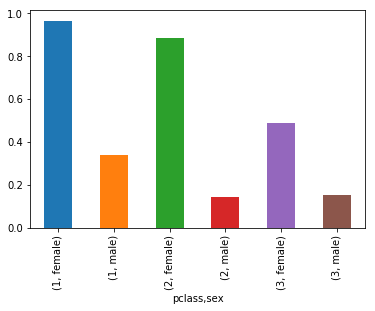

In [67]:
class_sex_grouping['survived'].plot.bar()

We can start drawing some interesting insights from this data. For instance, passengers in first class had a 62% chance of survival, compared to a 25.5% chance for those in 3rd class. Additionally, the lower classes generally consisted of younger people, and the ticket prices for first class were predictably much higher than those for second and third class. The average ticket price for first class (£87.5) is equivalent to $13,487 in 2016.

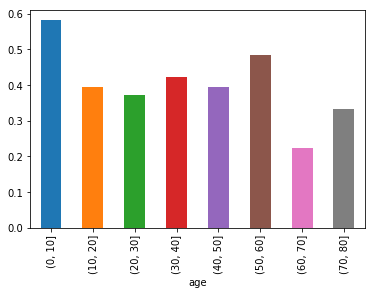

In [68]:
group_by_age = pd.cut(titanic_df["age"], np.arange(0, 90, 10))
age_grouping = titanic_df.groupby(group_by_age).mean()
age_grouping['survived'].plot.bar()

While the Titanic was sinking, the officers famously prioritized who was allowed in a lifeboat with the strict maritime tradition of evacuating women and children first. Our statistical results clearly reflect the first part of this policy as, across all classes, women were much more likely to survive than the men. We can also see that the women were younger than the men on average, were more likely to be traveling with family, and paid slightly more for their tickets.

The effectiveness of the second part of this “Women and children first” policy can be deduced by breaking down the survival rate by age.

## Now Machine Learning! WHY at all?

With analysis, we can draw some fairly straightforward conclusions from this data — being a woman, being in 1st class, and being a child were all factors that could boost your chances of survival during this disaster.

Let’s say we wanted to write a program to predict whether a given passenger would survive the disaster. This could be done through an elaborate system of nested if-else statements with some sort of weighted scoring system, but such a program would be long, tedious to write, difficult to generalize, and would require extensive fine tuning.  

This is where machine learning comes in: we will build a program that learns from the sample data to predict whether a given passenger would survive.

Preparing The Data.

In [69]:
titanic_df.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

Before we can feed our data set into a machine learning algorithm, we have to remove missing values and split it into training and test sets.  

If we perform a count of each column, we will see that much of the data on certain fields is missing. Most machine learning algorithms will have a difficult time handling missing values, so we will need to make sure that each row has a value for each column.

In [70]:
titanic_df= titanic_df.drop(['body','cabin','boat'], axis=1)

In [71]:
titanic_df["home.dest"] = titanic_df["home.dest"].fillna("NA")

In [72]:
titanic_df = titanic_df.dropna()

In [73]:
titanic_df.count()

pclass       1043
survived     1043
name         1043
sex          1043
age          1043
sibsp        1043
parch        1043
ticket       1043
fare         1043
embarked     1043
home.dest    1043
dtype: int64

Most of the rows are missing values for “boat” and “cabin”, so we will remove these columns from the data frame. A large number of rows are also missing the “home.dest” field; here we fill the missing values with “NA”. A significant number of rows are also missing an age value. We have seen above that age could have a significant effect on survival chances, so we will have to drop all of rows that are missing an age value. When we run the count command again, we can see that all remaining columns now contain the same number of values.

Now we need to format the remaining data in a way that our machine learning algorithms will accept.

In [74]:
def preprocess_titanic_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.sex = le.fit_transform(processed_df.sex)
    processed_df.embarked = le.fit_transform(processed_df.embarked)
    processed_df = processed_df.drop(['name','ticket','home.dest'],axis=1)
    return processed_df

In [75]:
processed_df = preprocess_titanic_df(titanic_df)

The “sex” and “embarked” fields are both string values that correspond to categories (i.e “Male” and “Female”) so we will run each through a preprocessor. This preprocessor will convert these strings into integer keys, making it easier for the classification algorithms to find patterns. For instance, “Female” and “Male” will be converted to 0 and 1 respectively. The “name”, “ticket”, and “home.dest” columns consist of non-categorical string values. These are difficult to use in a classification algorithm, so we will drop them from the data set.

In [76]:
X = processed_df.drop(['survived'], axis=1).values
y = processed_df['survived'].values

In [77]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2)

In [78]:
clf_dt = tree.DecisionTreeClassifier(max_depth=10)

In [79]:
clf_dt.fit (X_train, y_train)
clf_dt.score (X_test, y_test)

0.74641148325358853

Next, we separate the data set into two arrays: “X” containing all of the values for each row besides “survived”, and “y” containing only the “survived” value for that row. The classification algorithms will compare the attribute values of “X” to the corresponding values of “y” to detect patterns in how different attributes values tend to affect the survival of a passenger.

Finally, we break the “X” and “y” array into two parts each — a training set and a testing set. We will feed the training set into the classification algorithm to form a trained model. Once the model is formed, we will use it to classify the testing set, allowing us to determine the accuracy of the model. Here we have have made a 20/80 split, such that 80% of the dataset will be used for training and 20% will be used for testing.

## Classification

The tree first splits by sex, and then by class, since it has learned during the training phase that these are the two most important features for determining survival. The dark blue boxes indicate passengers who are likely to survive, and the dark orange boxes represent passengers who are almost certainly doomed. Interestingly, after splitting by class, the main deciding factor determining the survival of women is the ticket fare that they paid, while the deciding factor for men is their age (with children being much more likely to survive).

To create this tree, we first initialize an instance of an untrained decision tree classifier. (Here we will set the maximum depth of the tree to 10). Next we “fit” this classifier to our training set, enabling it to learn about how different factors affect the survivability of a passenger. Now that the decision tree is ready, we can “score” it using our test data to determine how accurate it is.

In [88]:
shuffle_validator = model_selection.ShuffleSplit(n_splits=20, test_size=0.2, train_size=0.8, random_state=0)
def test_classifier(clf):
    scores = model_selection.cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [89]:
test_classifier(clf_dt)

Accuracy: 0.7756 (+/- 0.02)


The resulting reading, 0.7756, means that the model correctly predicted the survival of 77% of the test set. Not bad for our first model.

If you are being an attentive, skeptical reader (as you should be), you might be thinking that the accuracy of the model could vary depending on which rows were selected for the training and test sets. We will get around this problem by using a shuffle validator.  

In [93]:
clf_rf = ensemble.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)

Accuracy: 0.7780 (+/- 0.02)


In [94]:
clf_gb = ensemble.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)

Accuracy: 0.8201 (+/- 0.02)


In [95]:
eclf = ensemble.VotingClassifier([('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb)])
test_classifier(eclf)

Accuracy: 0.8065 (+/- 0.02)


This shuffle validator applies the same random 20:80 split as before, but this time it generates 20 unique permutations of this split. By passing this shuffle validator as a parameter to the “cross_val_score” function, we can score our classifier against each of the different splits, and compute the average accuracy and standard deviation from the results.

The result shows that our decision tree classifier has an overall accuracy of 78%, although it can go up to 80% and down to 75% depending on the training/test split. Using scikit-learn, we can easily test other machine learning algorithms using the exact same syntax.

## DNN

In [115]:
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(processed_df)
tf_clf_dnn = tf.contrib.learn.DNNClassifier(hidden_units=[20, 40, 20], n_classes=2, feature_columns=feature_columns)
tf_clf_dnn.fit(X_train, y_train, steps=1000, batch_size=32)
tf_clf_dnn_survived = list(tf_clf_dnn.predict(X, as_iterable=True))
tf_clf_dnn_score = metrics.accuracy_score(y, tf_clf_dnn_survived)
print("Accuracy:%f"%tf_clf_dnn_score)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_session_config': None, '_evaluation_master': '', '_save_checkpoints_steps': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_save_checkpoints_secs': 600, '_master': '', '_save_summary_steps': 100, '_tf_random_seed': None, '_log_step_count_steps': 100, '_task_type': None, '_task_id': 0, '_model_dir': 'C:\\Users\\JOHNSO~1\\AppData\\Local\\Temp\\tmp4db7qm74', '_num_ps_replicas': 0, '_is_chief': True, '_num_worker_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_environment': 'local', '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020E62BB37F0>}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\JOHNSO~1\AppData\Local\Temp\tmp4db7qm74\model.ckpt.
INFO:tensorflow:step = 1, loss = 1.7857
INFO:tensorflow:global_step/sec: 731.988
INFO:tensorflow:step = 101, loss = 0.567038 (0.14

The “Random Forest” classification algorithm will create a multitude of (generally very poor) trees for the data set using different random subsets of the input variables, and will return whichever prediction was returned by the most trees. This helps to avoid “overfitting”, a problem that occurs when a model is so tightly fitted to arbitrary correlations in the training data that it performs poorly on test data.

The “Gradient Boosting” classifier will generate many weak, shallow prediction trees and will combine, or “boost”, them into a strong model. This model performs very well on our data set, but has the drawback of being relatively slow and difficult to optimize, as the model construction happens sequentially so it cannot be parallelized.

A “Voting” classifier can be used to apply multiple conceptually divergent classification models to the same data set and will return the majority vote from all of the classifiers. For instance, if the gradient boosting classifier predicts that a passenger will not survive, but the decision tree and random forest classifiers predict that they will live, the voting classifier will chose the latter.

This has been a very brief and non-technical overview of each technique, so I encourage you to learn more about the mathematical implementations of all of these algorithms to obtain a deeper understanding of their relative strengths and weaknesses. Many more classification algorithms are available “out-of-the-box” in scikit-learn and can be explored here: http://scikit-learn.org/stable/modules/ensemble.  

Given that the accuracy for all of our models is maxing out around 80%, it will be interesting to look at specific passengers for whom these classification algorithms are incorrect.

In [116]:
passengers_set_1 = titanic_df[titanic_df.pclass == 1].iloc[:20,:].copy()
passengers_set_2 = titanic_df[titanic_df.pclass == 2].iloc[:20,:].copy()
passengers_set_3 = titanic_df[titanic_df.pclass == 3].iloc[:20,:].copy()
passenger_set = pd.concat([passengers_set_1,passengers_set_2,passengers_set_3])
testing_set = preprocess_titanic_df(passenger_set)

In [117]:
training_set = pd.concat([titanic_df, passenger_set]).drop_duplicates(keep=False)
training_set = preprocess_titanic_df(training_set)

In [118]:
X_train = training_set.drop(['survived'], axis=1).values
y_train = training_set['survived'].values
X_test = testing_set.drop(['survived'], axis=1).values
y_test = testing_set['survived'].values

In [120]:
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(processed_df)
tf_clf_dnn = tf.contrib.learn.DNNClassifier(hidden_units=[20, 40, 20], n_classes=2, feature_columns=feature_columns)
tf_clf_dnn.fit(X_train, y_train, steps=1000, batch_size=32)
tf_clf_dnn_survived = list(tf_clf_dnn.predict(X, as_iterable=True))
tf_clf_dnn_score = metrics.accuracy_score(y, tf_clf_dnn_survived)
print("Accuracy:%f"%tf_clf_dnn_score)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_session_config': None, '_evaluation_master': '', '_save_checkpoints_steps': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_save_checkpoints_secs': 600, '_master': '', '_save_summary_steps': 100, '_tf_random_seed': None, '_log_step_count_steps': 100, '_task_type': None, '_task_id': 0, '_model_dir': 'C:\\Users\\JOHNSO~1\\AppData\\Local\\Temp\\tmpax2o2r8u', '_num_ps_replicas': 0, '_is_chief': True, '_num_worker_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_environment': 'local', '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020E67679278>}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\JOHNSO~1\AppData\Local\Temp\tmpax2o2r8u\model.ckpt.
INFO:tensorflow:step = 1, loss = 1.25807
INFO:tensorflow:global_step/sec: 601.979
INFO:tensorflow:step = 101, loss = 0.766661 (0.1

In [121]:
prediction = tf_clf_dnn.predict(X_test)
passenger_set[passenger_set.survived != prediction]

INFO:tensorflow:Restoring parameters from C:\Users\JOHNSO~1\AppData\Local\Temp\tmpax2o2r8u\model.ckpt-1000


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,S,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,S,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,S,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,S,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,S,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,C,"Montevideo, Uruguay"


The above table shows all of the passengers in our test data set whose survival (or lack thereof) was incorrectly classified by the neural network model.

Sometimes when you are dealing the data sets like this, the human side of the story can get lost beneath the complicated math and statistical analysis. By examining passengers for whom our classification model was incorrect, we can begin to uncover some of the most fascinating, and sometimes tragic, stories of humans defying the odds.

For instance, the first three incorrectly classified passengers are all members of the Allison family, who perished even though the model predicted that they would survive. These first class passengers were very wealthy, as can be evidenced by their far-above-average ticket prices. For Betsy (25) and Loraine (2) in particular, not surviving is very surprising, considering that we found earlier that over 96% of first class women lived through the disaster.  

So what happened? A surprising amount of information on each Titanic passenger is available online; it turns out that the Allison family was unable to find their youngest son Trevor and was unwilling to evacuate the ship without him. Tragically, Trevor was already safe in a lifeboat with his nurse and was the only member of the Allison family to survive the sinking.

## Conclusion

Initially I was disappointed by the accuracy of our machine learning models maxing out at about 80% for this data set. It’s easy to forget that these data points each represent real people, each of whom found themselves stuck on a sinking ship without enough lifeboats. When we looked into data points for which our model was wrong, we can uncover incredible stories of human nature driving people to defy their logical fate. It is important to never lose sight of the human element when analyzing this type of data set. This principle will be especially important going forward, as machine learning is increasingly applied to human data sets by organizations such as insurance companies, big banks, and law enforcement agencies.